In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

# Input data from Example 3 of Session 3
names = ['Asset1', 'Asset2', 'Asset3', 'Asset4']
exp_rets = pd.Series([0.05, 0.06, 0.08, 0.06], index = names)
vols = pd.Series([0.15, 0.20, 0.25, 0.30], index = names)
corr_mat =  np.array([
                     [1.0, 0.1, 0.4, 0.5],
                     [0.1, 1.0, 0.7, 0.4],
                     [0.4, 0.7, 1.0, 0.8],
                     [0.5, 0.4, 0.8, 1.0]
                    ])
corr_mat = pd.DataFrame(corr_mat, index = names, columns = names)

# different ways to get the covariance matrix from the correlations

# First approach: multiply the correlation matrix by the outer product of the volatilities
# the command np.outer(vols, vols) outputs a matrix with all cross-products of the volatilities
cov_mat = corr_mat * np.outer(vols, vols)
cov_mat

# Second approach: create a diagonal matrix D with the volatilities and then compute D * corr_mat * D
D = np.diag(vols)
cov_mat2 = D @ corr_mat.values @ D
cov_mat2 = pd.DataFrame(cov_mat2, index = names, columns = names)
cov_mat2

,Asset1,Asset2,Asset3,Asset4
Asset1,0.0225,0.003,0.0150,0.0225
Asset2,0.0030,0.040,0.0350,0.0240
Asset3,0.0150,0.035,0.0625,0.0600
Asset4,0.0225,0.024,0.0600,0.0900


In [2]:
from pypfopt import EfficientFrontier
from pypfopt import base_optimizer

# Example of calculation of MVP

# notice we provide 'None' for the expected returns, since MVP doesn't require it
ef = EfficientFrontier(None, cov_mat)

# The method below does the calculation of the MVP. By default it's assuming full
# investment as well as positive weights
ef.min_volatility()

# The portfolio weights can be obtained as such:
ef.weights

# Alternatively, the command below cleans it up a bit but returns an object of type OrderedDict
weights = ef.clean_weights()
weights

# You could also turn this into a pandas Series or numpy array
weights = pd.Series(weights)
weights

# calculating the performance of this portfolio. 
mvp_exp_ret = np.inner(exp_rets, weights)
mvp_vol = np.sqrt(weights @ cov_mat @ weights.T)
print(f'The expected return of the MVP without short sales is {mvp_exp_ret}')
print(f'The volatility of the MVP without short sales is {mvp_vol}')

# Alternatively, you can use the function portfolio_performance. The outputs are: expected return, volatility, Sharpe ratio
mvp_perf = base_optimizer.portfolio_performance(weights, exp_rets, cov_mat, risk_free_rate=0.0)

# Allowing short sales
ef_long_short = EfficientFrontier(None, cov_mat, weight_bounds=(-1, 1))
ef_long_short.min_volatility()
weights_long_short = ef_long_short.clean_weights()
weights_long_short = pd.Series(weights_long_short)
weights_long_short

mvp_long_short_perf = base_optimizer.portfolio_performance(weights_long_short, exp_rets, cov_mat, risk_free_rate=0.0)

# show performance in a more readable format
pd.DataFrame([mvp_perf, mvp_long_short_perf], index = ['MVP (no short sales)', 'MVP (short sales)'], columns = ['Exp.Ret', 'Vol', 'SR'])

OrderedDict([('Asset1', 0.6548672566371682),
             ('Asset2', 0.3451327433628318),
             ('Asset3', 0.0),
             ('Asset4', 0.0)])

array([0.65486726, 0.34513274, 0.        , 0.        ])

OrderedDict([('Asset1', 0.65487),
             ('Asset2', 0.34513),
             ('Asset3', 0.0),
             ('Asset4', 0.0)])

Asset1    0.65487
Asset2    0.34513
Asset3    0.00000
Asset4    0.00000
dtype: float64

The expected return of the MVP without short sales is 0.0534513
The volatility of the MVP without short sales is 0.12557830825763658


OrderedDict([('Asset1', 0.7274245164881036),
             ('Asset2', 0.4946431056073464),
             ('Asset3', -0.2045359677194933),
             ('Asset4', -0.0175316543759567)])

Asset1    0.72742
Asset2    0.49464
Asset3   -0.20454
Asset4   -0.01753
dtype: float64

,Exp.Ret,Vol,SR
MVP (no short sales),0.053451,0.125578,0.425641
MVP (short sales),0.048634,0.119951,0.405453


<Axes: xlabel='Volatility', ylabel='Return'>

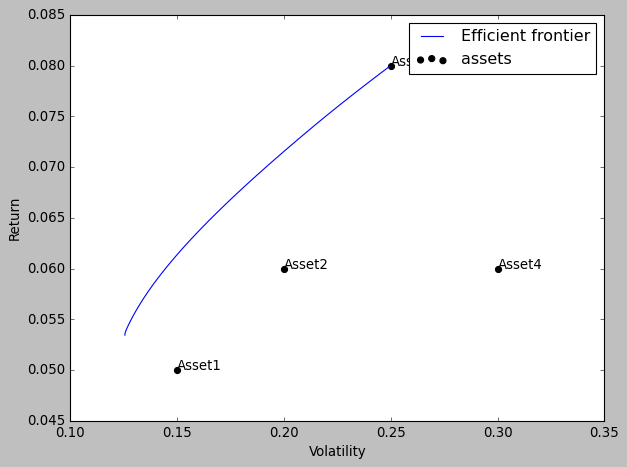

In [3]:
# Example - generating and plotting the efficient frontier
from pypfopt import plotting
import matplotlib.pyplot as plt
ef = EfficientFrontier(exp_rets, cov_mat)
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)
plt.show()

# Obs: if you get an error message "OSError: 'seaborn-deep' is not a valid package style...", find the file plotting.py in the pypfopt folder
# and replace the line plt.style.use("seaborn-deep") with plt.style.use("classic")

In [4]:
InteractiveShell.ast_node_interactivity = "last"

Text(0.155, 0.05, 'Asset1')

Text(0.20500000000000002, 0.06, 'Asset2')

Text(0.255, 0.08, 'Asset3')

Text(0.305, 0.06, 'Asset4')

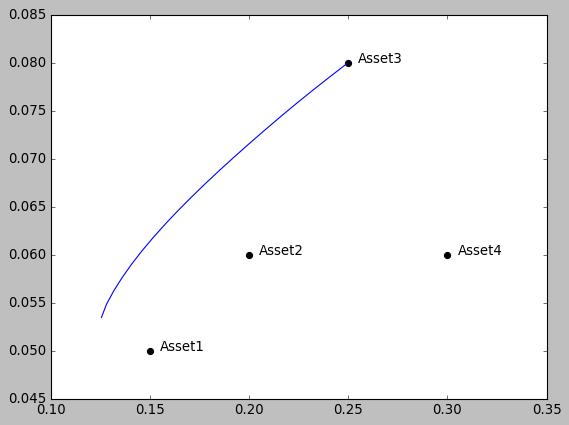

In [5]:


# Alternatively, we can reconstruct the frontier from the object ef by generating each efficient portfolio and storing the data

# first get the grid of expected returns used in the optimizations. 
# first set the number of portfolios
n_ports = 20 
ef = EfficientFrontier(exp_rets, cov_mat)
mu_grid = plotting._ef_default_returns_range(ef, n_ports)

# initialize mus and vols
ef_mu, ef_vols = [], []

# cycle through expected returns in the grid and get efficient portfolio performance
for mu_i in mu_grid:
    ef.efficient_return(mu_i)
    ret, sigma, _ = ef.portfolio_performance()
    ef_mu.append(ret)
    ef_vols.append(sigma)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(ef_vols, ef_mu, label = 'Efficient frontier')
ax.scatter(vols, exp_rets, s=30, color = "k")

for i, label in enumerate(names):
    ax.annotate(label, (vols.iloc[i]+.005, exp_rets.iloc[i]))

